# Summary of work

This notebook shows how various classes behave when embedded in UMAP or PaCMAP, and the effect of using a cosine or Euclidean distance metric. It also explores the effect of downsampling, both before and after embedding the MS2DS vectors. Between UMAP and PaCMAP, only PaCMAP is  considerably affected by downsampling the data before embedding.
The notebook also shows evidence that UMAP can work with separate seen and "unseen" data, and provides minimal working examples for plotting static UMAPs with seaborn and interactive UMAPs with plotly.express. 

# Import libraries, functions, and data

In [2]:
import pickle
import itertools
import numpy as np
import pandas as pd
import umap
import pacmap

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


def colour_dict(var_column, blackout_list=[]):
    # Creates a colour dictionary with 20 distinct colours. Blackout_list offers the possibility to directly assign the colour black to groups.  
    # If the number of groups in the variable column exceeds 20, the only largest groups will be given the distinct colours.
    # If the number of groups is smaller than 20, the first n colours will be used.
    # Colours by Sasha Trubetskoy at https://sashamaps.net/docs/resources/20-colors/
    
    colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#0000CD', '#800000', # replaced FFFAC8 (beige) with #0000CD (medium blue) for better visibility against white background
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080']
    groups = list(var_column.value_counts(ascending=False).index)
    for elem in blackout_list:
        groups.remove(elem)
    while (len(groups) > len(colours)):
           colours.append("#000000")
    colour_dict = dict(zip(groups, colours))
    for elem in blackout_list:
        colour_dict[elem] = "#000000"
    return colour_dict


def undersample_classes(spectrum_metadata, var, min_class_size, sample_size, random_state = 42):
    # Pass spectrum_metadata dataframe to function, and it will return a downsampled selection for you, from classes that satisfy the specified minimum class size
    # Multiclass spectra are automatically detected and ignored
    # If sample_size input is an integer, this will be the sample size.
    # If sample_size == "all" or any other non-integer, all spectra from the classes that satisfy the minimum class size will be be returned
    
    class_counts = spectrum_metadata[var].value_counts()
    class_counts = class_counts[class_counts>=min_class_size]
    selected_classes = class_counts[[';' not in s for s in class_counts.index]] # Discard multiclass labels
    selection = spectrum_metadata[spectrum_metadata[var].isin(selected_classes.index)]
    
    if (isinstance(sample_size, int)):
        class_dict = dict(selected_classes)
        class_dict = dict.fromkeys(class_dict, sample_size)
        resampler = RandomUnderSampler(sampling_strategy = class_dict, random_state = random_state)
        downsampled_selection = resampler.fit_resample(selection, selection[var])[0]
        metadata_indices = selection.iloc[resampler.sample_indices_].index # Get original indices by taking the sampled rows from the selection dataframe
        downsampled_selection.set_index(metadata_indices, inplace = True)  # Restore original indices
        return downsampled_selection
    return selection

In [7]:
data_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Data/"
embedding_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Embeddings/"
plot_dir = "C:/Users/Artur/Documents/Werk/Spec2Vec/Plots/"

# Load metadata of inchikey-annotated spectra
spectrum_metadata = pd.read_csv(data_dir+"GNPS_210409 Metadata inchi annotated spectra.csv", sep = "\t")

# Load MS2DS vectors
all_ms2ds = pd.read_pickle(embedding_dir+"MS2DeepScore_embedding_annotated_spectra_210409_joblib.pickle")

# Select only MS2DS vectors of annotated spectra, transform to dataframe
annotated_ms2ds = [all_ms2ds[i] for i in spectrum_metadata["spectrum_index"]]
spectrum_vectors = pd.DataFrame(np.vstack(annotated_ms2ds))

len(ms2ds) == len(spectrum_metadata)

True

In [47]:
spectrum_metadata

ID                     inchikey  \
0       CCMSLIB00000001547  IYDKWWDUBYWQGF-NNAZGLEUSA-N   
1       CCMSLIB00000001548  KNGPFNUOXXLKCN-ZNCJFREWSA-N   
2       CCMSLIB00000001549  WXDBUBIFYCCNLE-NSCMQRKRSA-N   
3       CCMSLIB00000001550  CGZKSPLDUIRCIO-RPCRKUJJSA-N   
4       CCMSLIB00000001552  USXIYWCPCGVOKF-LERJCCFDSA-N   
...                    ...                          ...   
187147  CCMSLIB00006112475  LKMNXYDUQXAUCZ-UHFFFAOYSA-N   
187148  CCMSLIB00006112480  NPJICTMALKLTFW-OFUAXYCQSA-N   
187149  CCMSLIB00006112482  KWDWBAISZWOAHD-SDTJYSPYSA-N   
187150  CCMSLIB00006112485  OVMFOVNOXASTPA-SDSMHRFWSA-N   
187151  CCMSLIB00006112486  KBPHJBAIARWVSC-NSIPBSJQSA-N   

                                                    inchi instrument  \
0       InChI=1S/C48H72N10O12/c1-25(2)22-36-45(66)57-3...       qTof   
1       InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...       qTof   
2       InChI=1S/C24H38ClNO5/c1-3-4-5-6-8-11-19(30-2)1...       qTof   
3       InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17...   Ion Trap   
4       InChI=1S/C27H34Cl2N2O9S2/c1-13-17(9-8-10-27(7,...       qTof   
...                                                   ...        ...   
187147  InChI=1S/C20H20O7/c1-22-13-7-6-11(8-15(13)23-2...   Orbitrap   
187148  InChI=1S/C35H60O6/c1-7-22(20(2)3)9-8-21(4)26-1...   Orbitrap   
187149  InChI=1S/C42H70O12/c1-21(2)10-9-11-22(3)23-12-...   Orbitrap   
187150  InChI=1S/C26H28O14/c27-6-13-18(32)21(35)23(37)...   Orbitrap   
187151  InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...   Orbitrap   

        spectrum_index                                             smiles  \
0                    0  CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...   
1                    1  CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...   
2                    2  CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...   
3                    3  OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...   
4                    5  C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...   
...                ...                                                ...   
187147          199775  COC1=C(C=C(C=C1)C2=CC(=O)C3=C(C(=C(C=C3O2)OC)O...   
187148          199776  CCC(CCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)OC5C(C...   
187149          199777  OCC1OC(OC2C(O)C(O)C(OC2OC3CCC4(C)C(CCC5(C)C4CC...   
187150          199778  O=C1C=C(OC2=C1C(O)=C(C(O)=C2C3OC(CO)C(O)C(O)C3...   
187151          199779  OC1C=C(C)C(C=CC(=CC=CC(=CC=CC=C(C=CC=C(C=CC2=C...   

               cf_kingdom                     cf_superclass  \
0       Organic compounds     Organic acids and derivatives   
1       Organic compounds     Organic acids and derivatives   
2       Organic compounds      Organoheterocyclic compounds   
3       Organic compounds      Organoheterocyclic compounds   
4       Organic compounds     Organic acids and derivatives   
...                   ...                               ...   
187147  Organic compounds  Phenylpropanoids and polyketides   
187148  Organic compounds   Lipids and lipid-like molecules   
187149  Organic compounds   Lipids and lipid-like molecules   
187150  Organic compounds  Phenylpropanoids and polyketides   
187151  Organic compounds   Lipids and lipid-like molecules   

                                cf_class                   cf_subclass  \
0                        Peptidomimetics               Hybrid peptides   
1                        Peptidomimetics                 Depsipeptides   
2                               Oxepanes                           NaN   
3                Indoles and derivatives                           NaN   
4                        Peptidomimetics                 Depsipeptides   
...                                  ...                           ...   
187147                        Flavonoids       O-methylated flavonoids   
187148  Steroids and steroid derivatives  Stigmastanes and derivatives   
187149                     Prenol lipids                 Triterpenoids   
187150                      

# Define models
For the models, I choose 50 neighbors which is on the smaller side of things, but speeds up the embedding process considerably compared to 200 neighbors. Meanwhile,the improvements typically yielded by using 200 neighbours are only modest. I set min_dist at a mid-high value to combat overplotting in the more dense plots while still accommodating clustering with smaller datasets. I fixed the random_state for the UMAPs to make fair comparisons between the downsampled data plots, and the plots with all data. PaCMAP also supports setting a random_state as of 0.5.0 (current version), but using it causes highly unusual and unusable results so I did not use it. Note that by setting n_neighbors to None, you allow the model to use an adaptive default value that scales with the size of the dataset, which I recommend. PaCMAP also has a "distance" parameter, but this parameter does not know cosine distance as of yet.

In [6]:
cosine_umap = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "cosine", random_state = 42)
euclidean_umap = umap.UMAP(n_components = 2, n_neighbors = 50, min_dist = 0.75, metric = "euclidean", random_state = 42)
default_pacmap = pacmap.PaCMAP(n_dims=2, n_neighbors = None) 

# Is UMAP's transform function reliable?

UMAP offers the possibility to train a UMAP model on one set of data, and transform unseen data using the same model. This is an enticing feature, but it's only as useful as it is accurate. Here we select all NPC Pathway classes larger than 3000 spectra, and create a stratified train/test split, with 10% reserved for testing. We fit a UMAP model with the training set, and use this model to embed the test set separately. Comparing the training and test plots, only the Fatty acids (blue class) and Alkaloids are faithful to the training data UMAP. The other classes from the test dataset are drawn down and to the left, into the area that is completely Alkaloids in the UMAP of the training data. I've run the code several times, with the same result. Due to time constraints, however, I can't explore this issue further.

In [43]:
var = "npc_pathway_results"
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
x = spectrum_vectors.iloc[selection.index]
y = selection[var]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, stratify = y)

In [44]:
fit_model = cosine_umap.fit(X_train)
test_embedding = fit_model.transform(X_test)

In [45]:
test_df = pd.DataFrame(test_embedding, index = y_test, columns = ["x", "y"])
train_df = pd.DataFrame(fit_model.embedding_, index = y_train, columns = ["x", "y"])

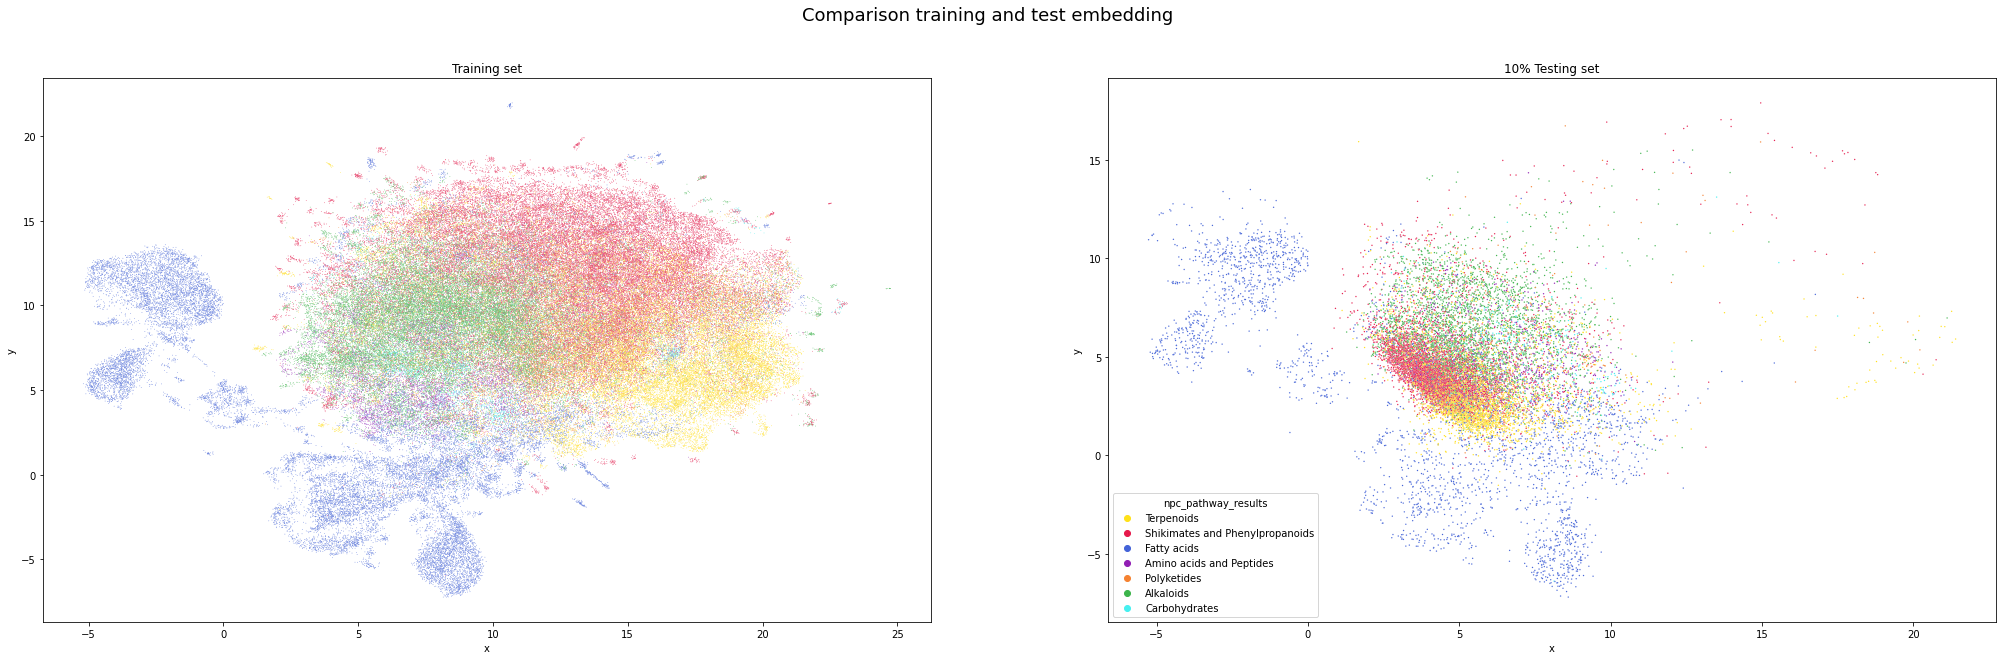

In [46]:
palette = colour_dict(y)

fig, axes = plt.subplots(1, 2, figsize=(35,10))
fig.suptitle("Comparison training and test embedding", fontsize = 18)
titles = ["Training set", "10% Testing set"]

sns.scatterplot(x = train_df["x"], y = train_df["y"], hue = train_df.index, s = 0.5, legend = False, palette = palette, ax = axes[0])
sns.scatterplot(x = test_df["x"], y = test_df["y"], hue = test_df.index, s = 2, legend = True, palette = palette, ax = axes[1])

for ax, title in zip(axes, titles):
    ax.set_title(title)

# NPC Pathway UMAPs

In [12]:
var = "npc_pathway_results"

# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
npc_pathway_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
npc_pathway_x_all = spectrum_vectors.iloc[selection.index]

In [13]:
%%time
x = [npc_pathway_x, npc_pathway_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
npc_pathway_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set
Finished complete set
Wall time: 8min 19s


In [14]:
with open(data_dir+"ms2ds_npc_pathway_umap.pickle", 'wb') as f:
        pickle.dump(npc_pathway_dfs, f)

In [15]:
with open(data_dir+"ms2ds_npc_pathway_umap.pickle", "rb") as f:
    npc_pathway_dfs = pickle.load(f)

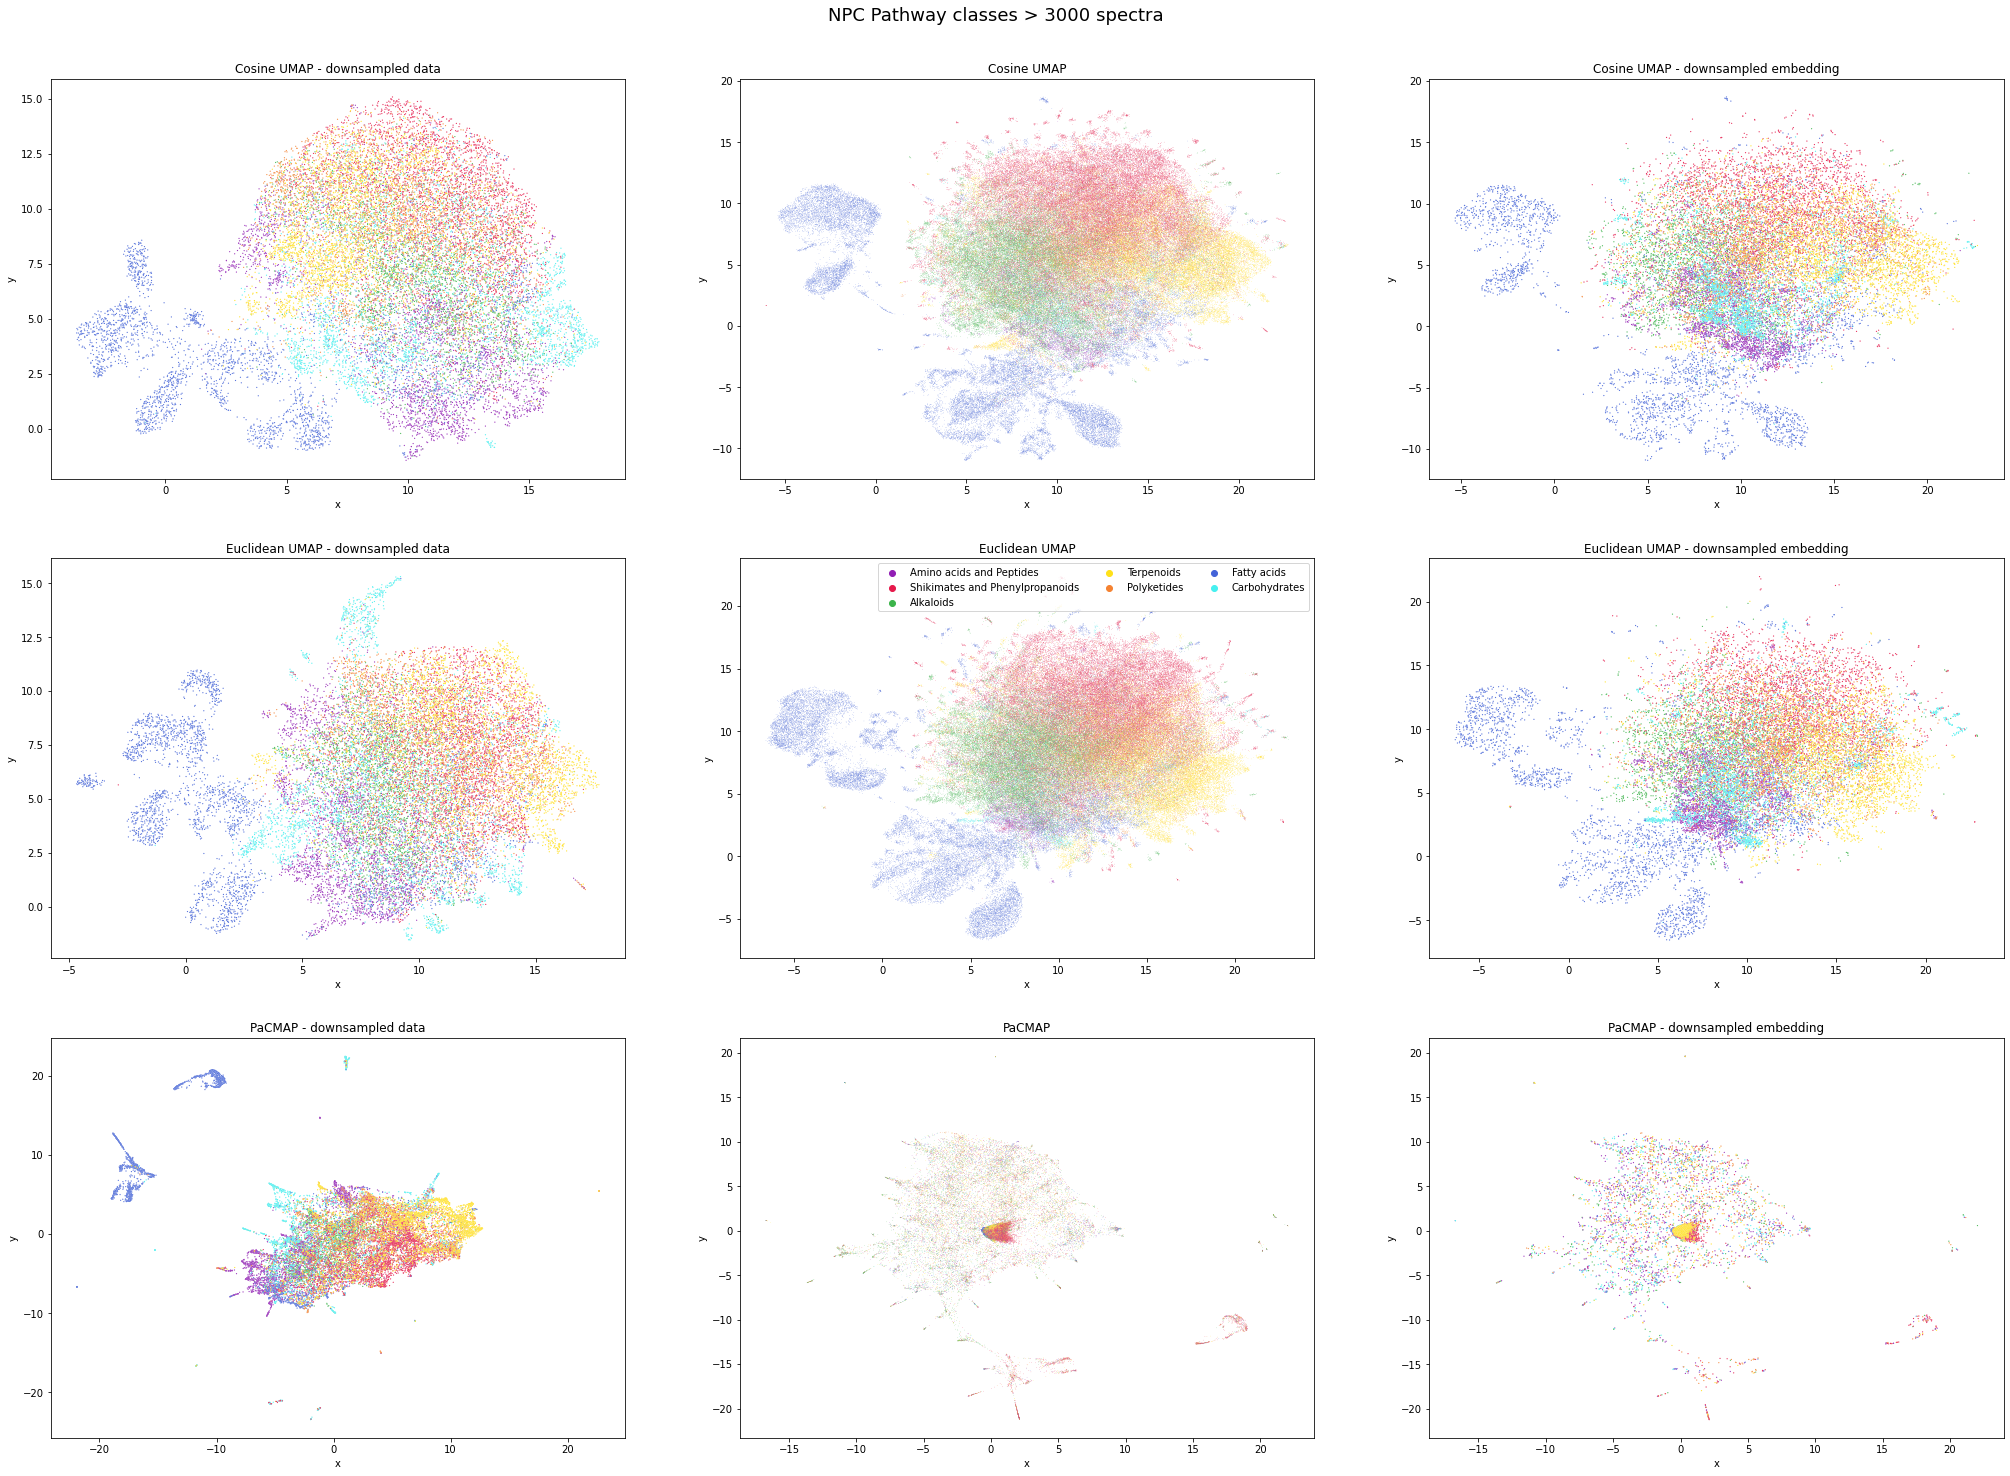

In [16]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = npc_pathway_dfs
var = "npc_pathway_results"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("NPC Pathway classes > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3)

fig.savefig(plot_dir+"MS2DS - NPC pathway UMAP summary.jpg")

# NPC Superclass UMAPs

In [17]:
var = "npc_superclass_results"

# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
npc_superclass_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
npc_superclass_x_all = spectrum_vectors.iloc[selection.index]

In [18]:
%%time
x = [npc_superclass_x, npc_superclass_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished downsampled UMAP set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
npc_superclass_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set
Finished downsampled UMAP set
Wall time: 7min 18s


In [20]:
with open(data_dir+"ms2ds_npc_superclass_umap.pickle", 'wb') as f:
        pickle.dump(npc_superclass_dfs, f)

In [21]:
with open(data_dir+"ms2ds_npc_superclass_umap.pickle", "rb") as f:
    npc_superclass_dfs = pickle.load(f)

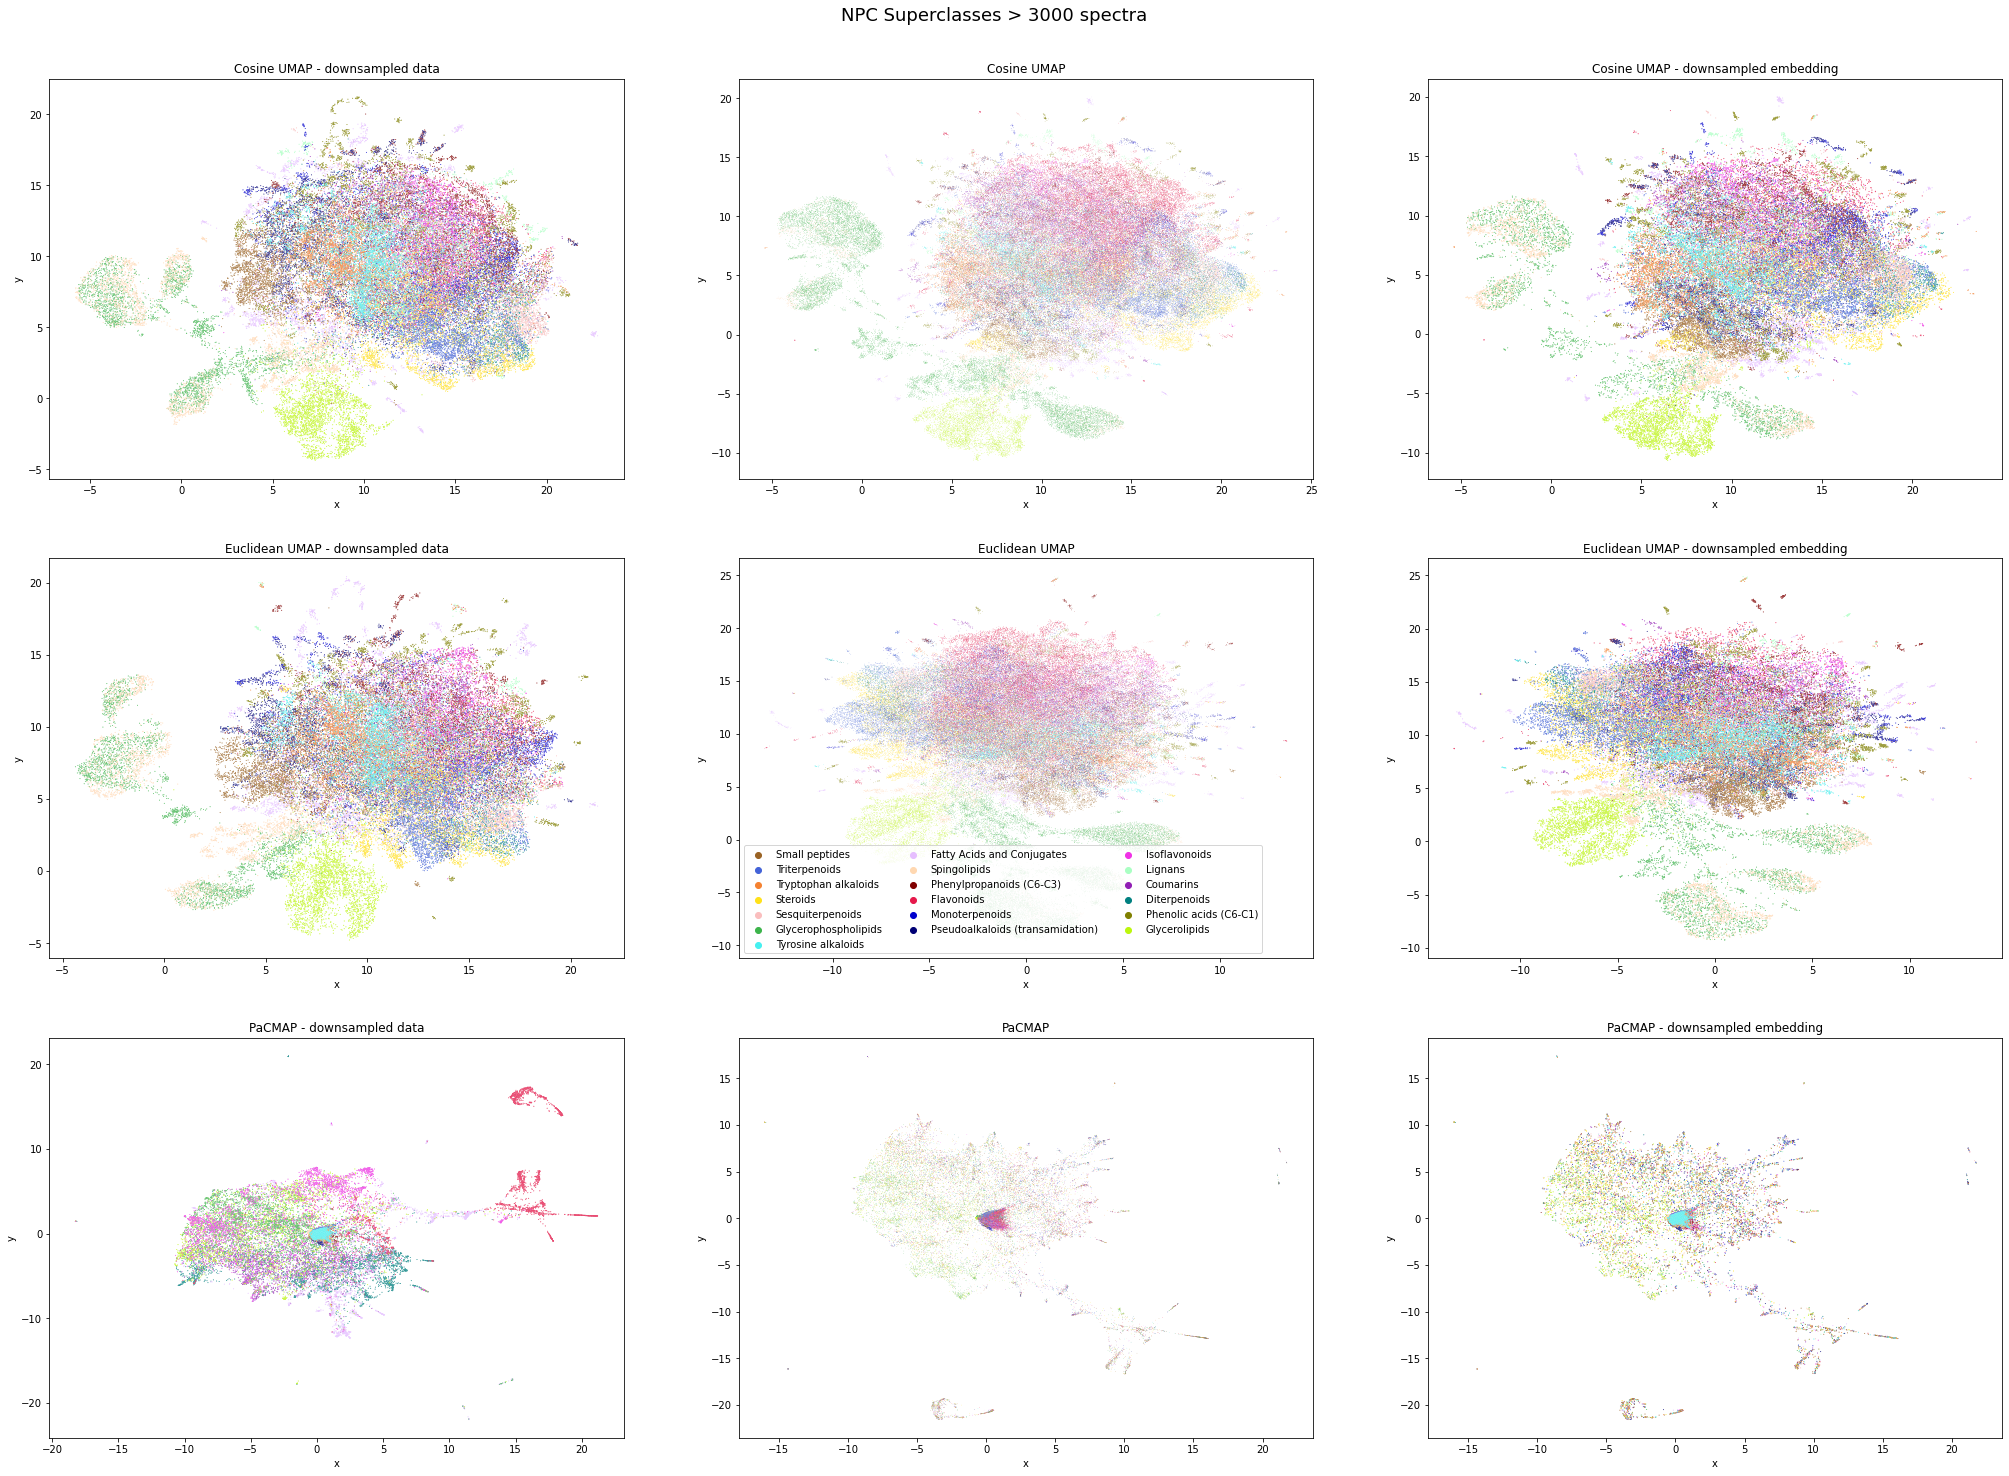

In [23]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = npc_superclass_dfs
var = "npc_superclass_results"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1, 0.2, 1]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("NPC Superclasses > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3)

fig.savefig(plot_dir+"MS2DS - NPC superclass UMAP summary.jpg")

# CF Superclass UMAPs

In [24]:
var = "cf_superclass"
spectrum_metadata[var].value_counts()

Lipids and lipid-like molecules              56916
Phenylpropanoids and polyketides             41958
Organoheterocyclic compounds                 22425
Benzenoids                                   18049
Organic acids and derivatives                11631
Alkaloids and derivatives                     9007
Organic oxygen compounds                      8693
Lignans, neolignans and related compounds     2539
Nucleosides, nucleotides, and analogues       1920
Organic nitrogen compounds                    1409
Hydrocarbons                                   317
Organosulfur compounds                         235
Hydrocarbon derivatives                        219
Organic Polymers                                81
Organophosphorus compounds                      42
Organometallic compounds                        33
Organohalogen compounds                         25
Organic 1,3-dipolar compounds                   13
Homogeneous non-metal compounds                  9
Name: cf_superclass, dtype: int

In [25]:
# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
cf_superclass_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
cf_superclass_x_all = spectrum_vectors.iloc[selection.index]

In [26]:
%%time
x = [cf_superclass_x, cf_superclass_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
cf_superclass_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set
Finished complete set
Wall time: 7min 47s


In [27]:
with open(data_dir+"ms2ds_cf_superclass_umap.pickle", 'wb') as f:
        pickle.dump(cf_superclass_dfs, f)

In [28]:
with open(data_dir+"ms2ds_cf_superclass_umap.pickle", "rb") as f:
    cf_superclass_dfs = pickle.load(f)

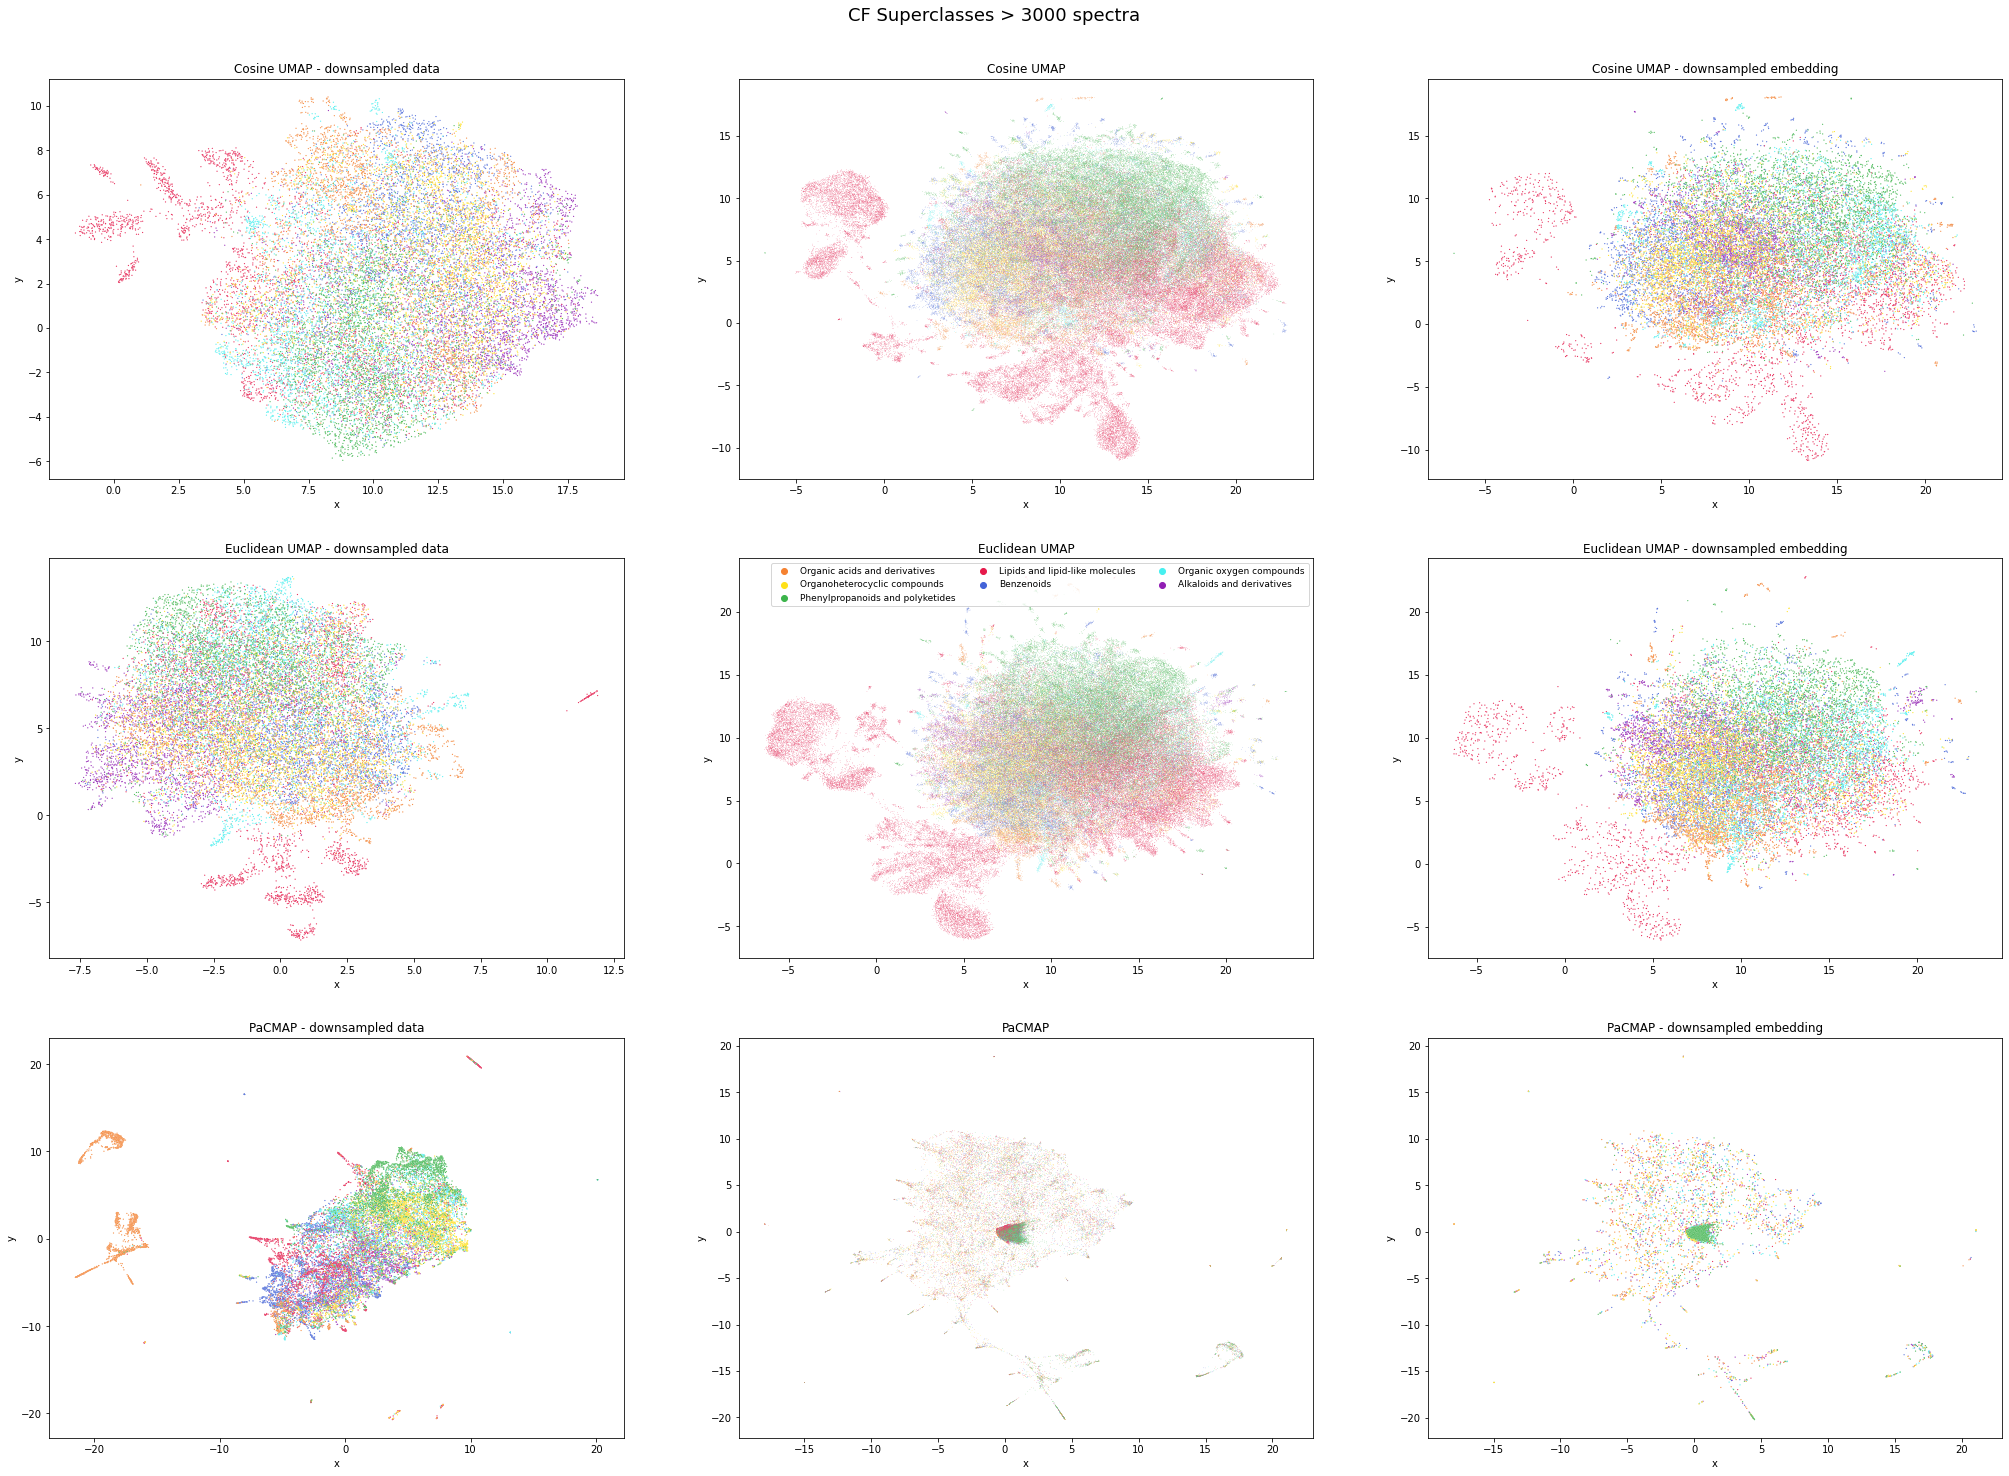

In [29]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = cf_superclass_dfs
var = "cf_superclass"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("CF Superclasses > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3, fontsize = 9) # The classes of this figure have longer names. I shrank the fontsize from 10 to 9 so the legend will fit within the plot.

fig.savefig(plot_dir+"MS2DS - CF superclass UMAP summary.jpg")

# CF class UMAPs

In [30]:
var = "cf_class"
spectrum_metadata[var].value_counts()

Prenol lipids                          23618
Flavonoids                             19482
Glycerophospholipids                   12517
Benzene and substituted derivatives    12358
Steroids and steroid derivatives        9580
                                       ...  
Cyclobutane lignans                        1
Pavine alkaloids                           1
Thienodiazepines                           1
Imidazodiazepines                          1
Other non-metal organides                  1
Name: cf_class, Length: 278, dtype: int64

In [31]:
# Downsample to 3000 spectra
selection = undersample_classes(spectrum_metadata, var, 3000, 3000)
cf_class_x = spectrum_vectors.iloc[selection.index]

# Use all spectra
selection = undersample_classes(spectrum_metadata, var, 3000, "all")
cf_class_x_all = spectrum_vectors.iloc[selection.index]

In [32]:
%%time
x = [cf_class_x, cf_class_x_all]

# Downsampled set
downsampled_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[0]), columns = ["x", "y"], index = x[0].index)
    downsampled_dfs.append(df)
print("Finished downsampled set")

# Complete set
complete_dfs = []
for model in [cosine_umap, euclidean_umap, default_pacmap]:
    df = pd.DataFrame(model.fit_transform(x[1]), columns = ["x", "y"], index = x[1].index)
    complete_dfs.append(df)
print("Finished complete set")

# Downsample the complete set's embedding
downsampled_embeddings = []
for downsampled_df, complete_df in zip(downsampled_dfs, complete_dfs):
    downsampled_embeddings.append(complete_df.loc[downsampled_df.index])

# Interleave the three lists, so each model has one row in a 3x3 grid, and each dataset one column
cf_class_dfs = list(itertools.chain(*zip(downsampled_dfs, complete_dfs, downsampled_embeddings)))

Finished downsampled set
Finished complete set
Wall time: 5min 54s


In [33]:
with open(data_dir+"ms2ds_cf_class_umap.pickle", 'wb') as f:
        pickle.dump(cf_class_dfs, f)

In [34]:
with open(data_dir+"ms2ds_cf_class_umap.pickle", "rb") as f:
    npc_class_dfs = pickle.load(f)

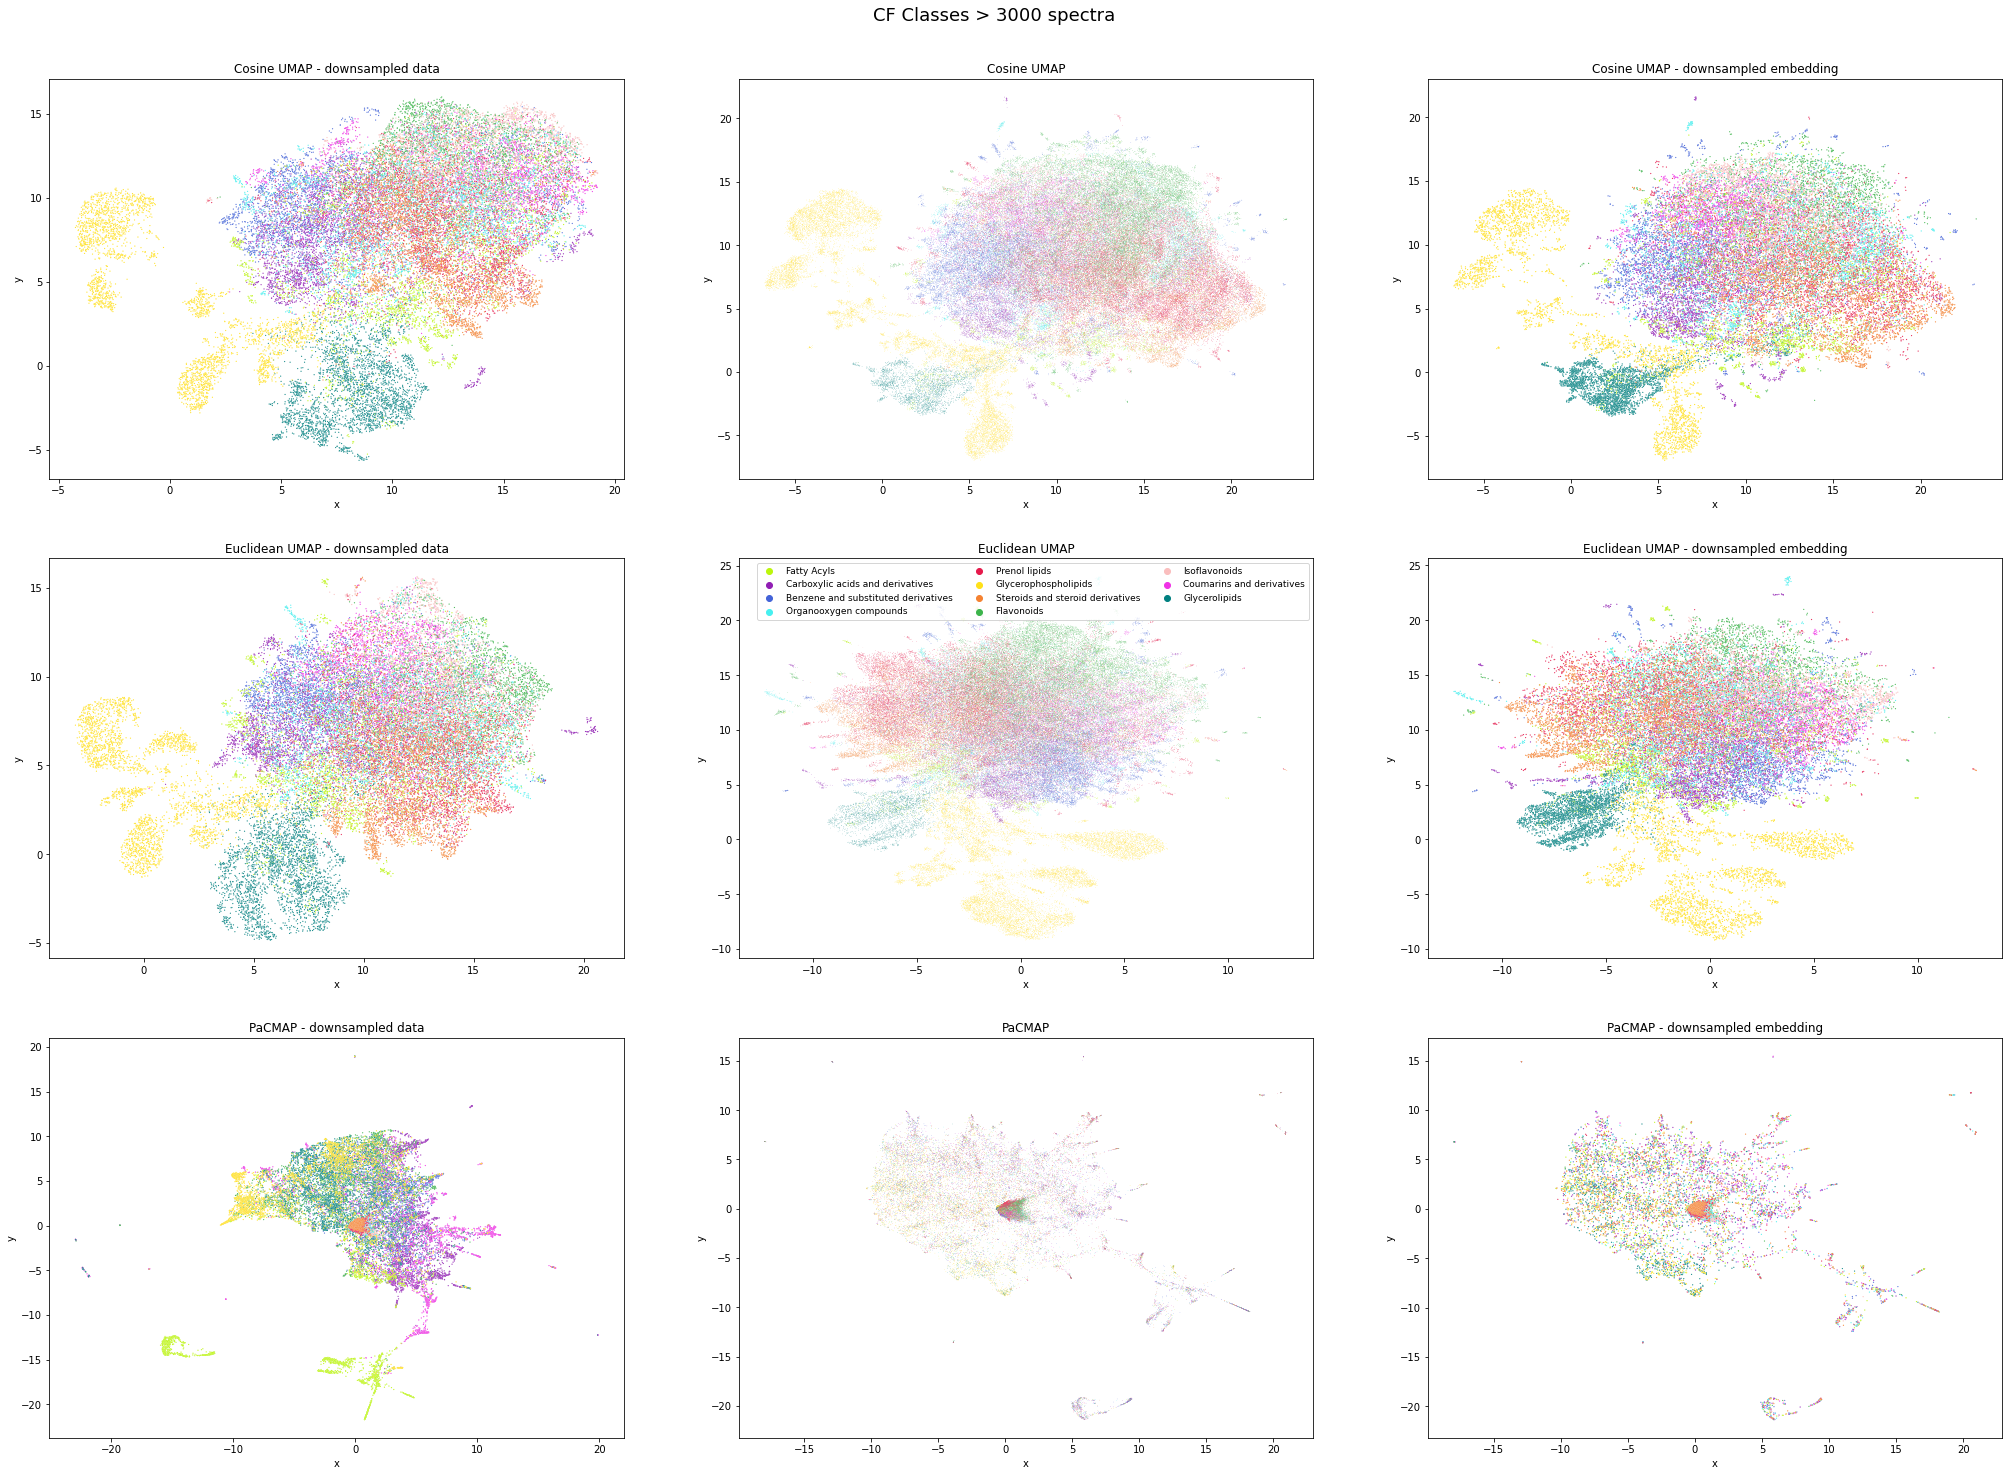

In [35]:
# All plot-specific data is renamed here at the top, don't forget to update the figure title though
umaps = cf_class_dfs
var = "cf_class"

target = spectrum_metadata.iloc[umaps[0].index][var]
target_all = spectrum_metadata.iloc[umaps[1].index][var]
palette = colour_dict(target_all)

plot_hue = 3*[target, target_all, target]
sizes = 3*[1.5, 0.2, 1.5]

# When iterating over axes, you always go row-wise, from left to right
titles = ["Cosine UMAP - downsampled data", "Cosine UMAP", "Cosine UMAP - downsampled embedding",
          "Euclidean UMAP - downsampled data", "Euclidean UMAP", "Euclidean UMAP - downsampled embedding", 
          "PaCMAP - downsampled data", "PaCMAP", "PaCMAP - downsampled embedding"]
fig, axes = plt.subplots(3, 3, figsize=(35,25))
fig.suptitle("CF Classes > 3000 spectra", fontsize = 18, y = 0.92)

for i, (df, hue, size, title, ax) in enumerate(zip(umaps, plot_hue, sizes, titles, axes.flatten())):
    sns.scatterplot(data = df, x = "x", y = "y", s = size, hue = hue, palette = palette, ax=ax)
    ax.set_title(title)

# Remove all legends, except for the legend of the center plot    
for i in [i for i in range(9) if i != 4]:
    axes.flatten()[i].get_legend().remove()
axes.flatten()[4].legend(loc='best', ncol=3, fontsize = 9) # The classes of this figure have longer names. I shrank the fontsize from 10 to 9 so the legend will fit within the plot.

fig.savefig(plot_dir+"MS2DS - CF class UMAP summary.jpg")